Fisher's Exact Test: Asks, "After pooling all the counts, is the proportion of APOBEC mutations out of the total different between my genetic backgrounds?"

Mann-Whitney U Test on Ratios: Asks, "Is the median ratio from the individual replicates different between my genetic backgrounds?" With n=3, this test has very little statistical power and is unlikely to find a significant difference.


This is why we show the following analysis:

Sum the non-apobec mutations and apobec related mutations over all 3 replicates, construct contingency tables and run Fishers exact test.
The resulting barplots show the ratio percents from the summed results, with individual dots showing the variability between replicates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

In [ ]:
sample_map = pd.read_csv('../../data/metadata/days_combined_sample_sheet.csv', sep=';')
sample_map


# Get a list of all CSV files in the current directory
csv_files = glob.glob('../../data/apobex4_signature_contribution/*.csv')

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Read and concatenate all CSV files into one DataFrame
for f in csv_files:
    temp_df = pd.read_csv(f, sep=',', index_col=0)
    all_data = pd.concat([all_data, temp_df], axis=1)

all_data = all_data.T

# Reset the index of all_data and rename the index column to 'sample_ID'
all_data_reset = all_data.reset_index().rename(columns={'index': 'sample_ID'})

# Merge the dataframes
merged_data = pd.merge(all_data_reset, sample_map, on='sample_ID')

merged_data['total_mutations'] = merged_data.iloc[:, 1:8].sum(axis=1)

merged_data['apobec_mutations'] = merged_data.iloc[:, [2, 5]].sum(axis=1)

merged_data[['total_mutations', 'apobec_mutations']] = merged_data[['total_mutations', 'apobec_mutations']].round().astype(int)

merged_data['APOBEC_ratio'] = merged_data['apobec_mutations'] / merged_data['total_mutations']

merged_data['APOBEC_ratio_percent'] = merged_data['APOBEC_ratio'] * 100

# calculate summed mutation numbers and run Fisher's exact

In [3]:
# Group by clone and genotype, sum the mutation counts, then recalculate ratios
sum_ratio_df = merged_data.groupby(['clone', 'E3_genotype'])[['total_mutations', 'apobec_mutations']].sum().reset_index()

# Calculate APOBEC_ratio and APOBEC_ratio_percent from the summed data
sum_ratio_df['APOBEC_ratio'] = sum_ratio_df['apobec_mutations'] / sum_ratio_df['total_mutations']
sum_ratio_df['APOBEC_ratio_percent'] = sum_ratio_df['APOBEC_ratio'] * 100


In [4]:
from scipy.stats import fisher_exact

# List of clones
clones = merged_data['clone'].unique()

# Define the control genotype
control_genotype = 'sgAAVS1'

# Get all other genotypes
other_genotypes = [genotype for genotype in merged_data['E3_genotype'].unique() if genotype != control_genotype]

# Create an empty dictionary to store the contingency tables and results
fisher_results = {}

# Loop through each clone
for clone in clones:
    fisher_results[clone] = {}
    
    # Loop through each other genotype
    for genotype in other_genotypes:
        fisher_results[clone][genotype] = {}
        
        # Filter the data for the current clone and control genotype
        control_subset = merged_data[(merged_data['clone'] == clone) & (merged_data['E3_genotype'] == control_genotype)]

        # Filter the data for the current clone and other genotype
        other_subset = merged_data[(merged_data['clone'] == clone) & (merged_data['E3_genotype'] == genotype)]

        # Calculate the sums of apobec_mutations and total_mutations for the control group
        control_apobec_sum = control_subset['apobec_mutations'].sum()
        control_total_sum = control_subset['total_mutations'].sum()
        control_non_apobec_sum = control_total_sum - control_apobec_sum
        
        # Calculate the sums of apobec_mutations and total_mutations for the other genotype group
        other_apobec_sum = other_subset['apobec_mutations'].sum()
        other_total_sum = other_subset['total_mutations'].sum()
        other_non_apobec_sum = other_total_sum - other_apobec_sum
        
        # Create the contingency table
        contingency_table = [[control_apobec_sum, control_non_apobec_sum],
                             [other_apobec_sum, other_non_apobec_sum]]
        
        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        
        # Store the contingency table and results
        fisher_results[clone][genotype] = {'contingency_table': contingency_table,
                                            'odds_ratio': odds_ratio,
                                            'p_value': p_value}




In [2]:
from statsmodels.stats.contingency_tables import Table2x2

def calc_CI_fisher(contingency_table, alpha=0.05):
    table = Table2x2(np.array(contingency_table))
    ci_low, ci_high = table.oddsratio_confint(method='exact-conditional', alpha=alpha)
    return ci_low, ci_high

In [7]:
# Convert fisher_results to a more readable DataFrame
fisher_df_data = []

for clone in fisher_results.keys():
    for genotype in fisher_results[clone].keys():
        fisher_df_data.append({
            'clone': clone,
            'genotype': genotype,
            'odds_ratio': fisher_results[clone][genotype]['odds_ratio'],
            'p_value': fisher_results[clone][genotype]['p_value'],
            #bonferroni correction
            'p_adjusted': fisher_results[clone][genotype]['p_value'] * 3,
            # Confidence Intervals
            'ci_low': calc_CI_fisher(fisher_results[clone][genotype]['contingency_table'])[0],
            'ci_high': calc_CI_fisher(fisher_results[clone][genotype]['contingency_table'])[1]
        })

fisher_df = pd.DataFrame(fisher_df_data)
fisher_df

,clone,genotype,odds_ratio,p_value,p_adjusted,ci_low,ci_high
0,RA1,sgUBR4,0.669489,8.428718e-48,2.528615e-47,0.634133,0.706815
1,RA1,sgUBR5,2.571492,1.132297e-187,3.396891e-187,2.410226,2.743549
2,RA1,sgHUWE1,0.584038,3.669722e-80,1.100917e-79,0.552502,0.617375
3,R2+219,sgUBR4,1.028138,5.153662e-01,1.546099e+00,0.947207,1.115984
4,R2+219,sgUBR5,0.345160,6.989625e-192,2.096888e-191,0.320140,0.372135
5,R2+219,sgHUWE1,0.690112,3.988330e-20,1.196499e-19,0.636887,0.747786
6,R2,sgUBR4,1.767441,5.410108e-36,1.623032e-35,1.612402,1.937387
7,R2,sgUBR5,0.532971,2.514519e-96,7.543556e-96,0.501373,0.566562
8,R2,sgHUWE1,0.986326,7.419686e-01,2.225906e+00,0.909982,1.069076


## plotting without individual data points

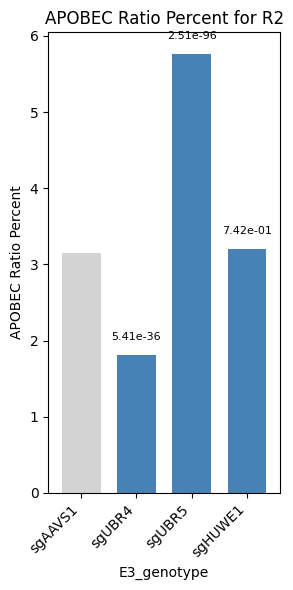

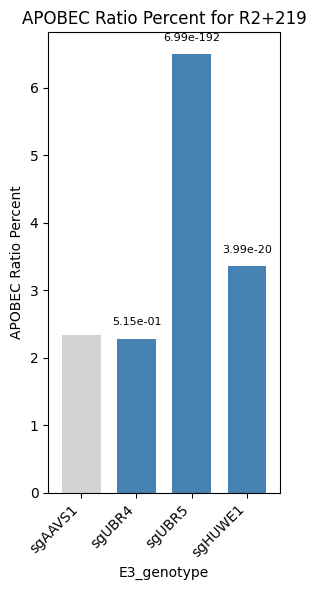

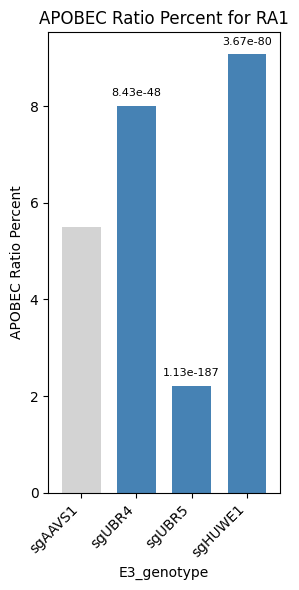

In [9]:
genotype_order = ['sgAAVS1', 'sgUBR4', 'sgUBR5', 'sgHUWE1']
colors = ['lightgrey','steelblue', 'steelblue','steelblue']

for clone in sum_ratio_df['clone'].unique():
    clone_data = sum_ratio_df[sum_ratio_df['clone'] == clone].copy()
    
    # Set E3_genotype as index and reindex to ensure correct order
    clone_data = clone_data.set_index('E3_genotype')
    clone_data = clone_data.reindex(genotype_order)
    
    plt.figure(figsize=(3, 6))
    bars = clone_data['APOBEC_ratio_percent'].plot(kind='bar', color=colors, width=0.7)
    plt.title(f'APOBEC Ratio Percent for {clone}')
    plt.ylabel('APOBEC Ratio Percent')
    plt.xticks(rotation=45, ha='right')
    
    # Add p-values above bars for non-control genotypes
    for i, genotype in enumerate(genotype_order):
        if genotype != control_genotype:  # Skip control genotype
            # Get p-value from fisher_df
            p_val_row = fisher_df[(fisher_df['clone'] == clone) & (fisher_df['genotype'] == genotype)]
            if not p_val_row.empty:
                p_value = p_val_row['p_value'].iloc[0]
                # Get the bar height for positioning
                bar_height = clone_data.loc[genotype, 'APOBEC_ratio_percent']
                if pd.notna(bar_height):  # Only add text if bar exists
                    plt.text(i, bar_height + 0.2, f'{p_value:.2e}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'APOBEC_Ratio_Percent_no_dots_{clone}.svg')
    plt.show()
    


## plotting with individual datapoints

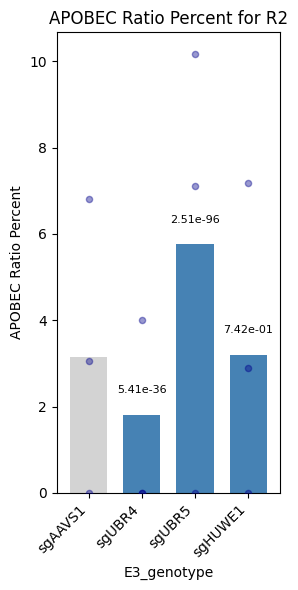

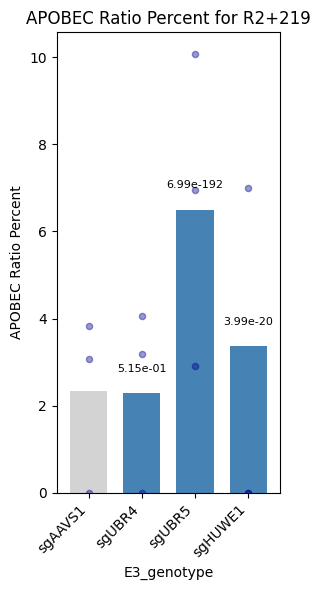

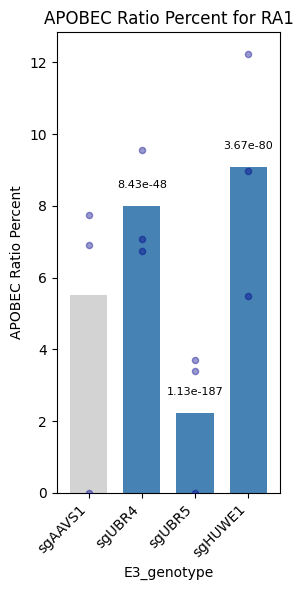

In [10]:
genotype_order = ['sgAAVS1', 'sgUBR4', 'sgUBR5', 'sgHUWE1']
colors = ['lightgrey','steelblue', 'steelblue','steelblue']

for clone in sum_ratio_df['clone'].unique():
    clone_data = sum_ratio_df[sum_ratio_df['clone'] == clone].copy()
    
    # Set E3_genotype as index and reindex to ensure correct order
    clone_data = clone_data.set_index('E3_genotype')
    clone_data = clone_data.reindex(genotype_order)
    
    plt.figure(figsize=(3, 6))
    bars = clone_data['APOBEC_ratio_percent'].plot(kind='bar', color=colors, width=0.7)
    plt.title(f'APOBEC Ratio Percent for {clone}')
    plt.ylabel('APOBEC Ratio Percent')
    plt.xticks(rotation=45, ha='right')
    
    # Add individual data points from replicates
    individual_data = merged_data[merged_data['clone'] == clone]
    for i, genotype in enumerate(genotype_order):
        genotype_replicates = individual_data[individual_data['E3_genotype'] == genotype]
        if not genotype_replicates.empty:
            plt.scatter([i] * len(genotype_replicates), 
                       genotype_replicates['APOBEC_ratio_percent'], 
                       color='darkblue', alpha=0.4, s=20, zorder=3)
    
    # Add p-values above bars for non-control genotypes
    for i, genotype in enumerate(genotype_order):
        if genotype != control_genotype:  # Skip control genotype
            # Get p-value from fisher_df
            p_val_row = fisher_df[(fisher_df['clone'] == clone) & (fisher_df['genotype'] == genotype)]
            if not p_val_row.empty:
                p_value = p_val_row['p_value'].iloc[0]
                # Get the bar height for positioning
                bar_height = clone_data.loc[genotype, 'APOBEC_ratio_percent']
                if pd.notna(bar_height):  # Only add text if bar exists
                    plt.text(i, bar_height + 0.5, f'{p_value:.2e}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'APOBEC_Ratio_Percent_dots_{clone}.svg')
    plt.show()
    

## same thing for the controls

In [ ]:
control_df = merged_data[((merged_data['clone'] == 'RA1') | (merged_data['clone'] == 'R2')) & (merged_data['E3_genotype'] == 'sgAAVS1')]

In [12]:
# Group by clone and genotype, sum the mutation counts, then recalculate ratios
control_sum_ratio_df = control_df.groupby('clone')[['total_mutations', 'apobec_mutations']].sum().reset_index()

# Calculate APOBEC_ratio and APOBEC_ratio_percent from the summed data
control_sum_ratio_df['APOBEC_ratio'] = control_sum_ratio_df['apobec_mutations'] / control_sum_ratio_df['total_mutations']
control_sum_ratio_df['APOBEC_ratio_percent'] = control_sum_ratio_df['APOBEC_ratio'] * 100


In [13]:
from scipy.stats import fisher_exact

# List of clones
clones = control_df['clone'].unique()


# Create an empty dictionary to store the contingency tables and results
fisher_results = {}

# Get the two clones from control_df
clone_list = control_df['clone'].unique()

# Sum mutations for each clone
clone_stats = {}
for clone in clone_list:
    clone_data = control_df[control_df['clone'] == clone]
    total_sum = clone_data['total_mutations'].sum()
    apobec_sum = clone_data['apobec_mutations'].sum()
    non_apobec_sum = total_sum - apobec_sum
    
    clone_stats[clone] = {
        'total_mutations': int(total_sum),
        'apobec_mutations': int(apobec_sum),
        'non_apobec_mutations': int(non_apobec_sum)
    }

# Create contingency table comparing the two clones
clone1, clone2 = clone_list[0], clone_list[1]
contingency_table = [
    [clone_stats[clone1]['apobec_mutations'], clone_stats[clone1]['non_apobec_mutations']],
    [clone_stats[clone2]['apobec_mutations'], clone_stats[clone2]['non_apobec_mutations']]
]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

# Store results
fisher_results[f'{clone1}_vs_{clone2}'] = {
    'contingency_table': contingency_table,
    'odds_ratio': odds_ratio,
    'p_value': p_value,
    'clone_stats': clone_stats
}

fisher_df_control = pd.DataFrame.from_dict(fisher_results, orient='index')
fisher_df_control['ci_low'], fisher_df_control['ci_high'] = zip(*fisher_df_control['contingency_table'].apply(calc_CI_fisher))
fisher_df_control

,contingency_table,odds_ratio,p_value,clone_stats,ci_low,ci_high
R2_vs_RA1,"[[1537, 47196], [2566, 44032]]",0.558831,4.413451e-72,"{'R2': {'total_mutations': 48733, 'apobec_muta...",0.523905,0.596085


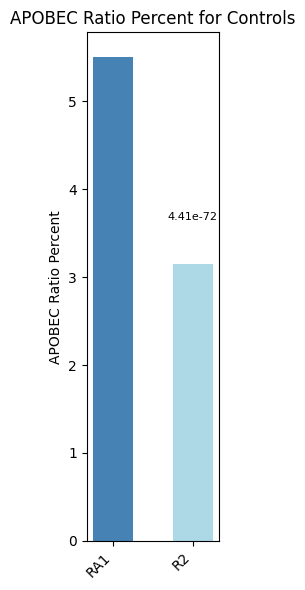

In [ ]:
plt.figure(figsize=(2, 6))

# Reorder the data to have RA1 first
reordered_data = control_sum_ratio_df.iloc[[1, 0]]  # RA1 first, then R2

# Create bar plot with reordered data
bars = plt.bar(reordered_data['clone'], reordered_data['APOBEC_ratio_percent'], 
               color=['steelblue', 'lightblue'], width=0.5)

plt.title('APOBEC Ratio Percent for Controls')
plt.ylabel('APOBEC Ratio Percent')
plt.xticks(rotation=45, ha='right')

# Add p-value above the second bar (R2)
p_value = fisher_df_control['p_value'].iloc[0]
bar_height = reordered_data['APOBEC_ratio_percent'].iloc[1]  # Height of R2 bar
plt.text(1, bar_height + 0.5, f'{p_value:.2e}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(f'Control_APOBEC_Ratio_Percent_no_dots.svg')
plt.show()


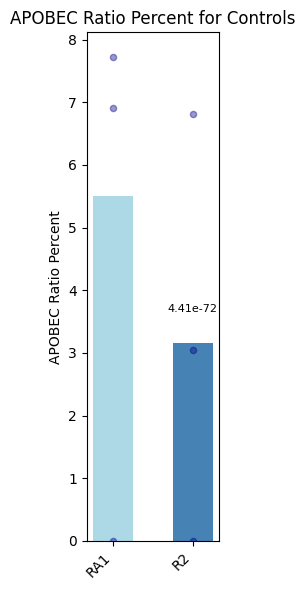

In [ ]:
plt.figure(figsize=(2, 6))

# Reorder the data to have RA1 first
reordered_data = control_sum_ratio_df.iloc[[1, 0]]  # RA1 first, then R2

# Create bar plot with reordered data
bars = plt.bar(reordered_data['clone'], reordered_data['APOBEC_ratio_percent'], 
               color=['lightblue', 'steelblue'], width=0.5)

plt.title('APOBEC Ratio Percent for Controls')
plt.ylabel('APOBEC Ratio Percent')
plt.xticks(rotation=45, ha='right')

# Add individual data points from replicates
for i, clone in enumerate(reordered_data['clone']):
    clone_replicates = control_df[control_df['clone'] == clone]
    plt.scatter([i] * len(clone_replicates), 
               clone_replicates['APOBEC_ratio_percent'], 
               color='darkblue', alpha=0.4, s=20, zorder=3)

# Add p-value above the second bar (R2)
p_value = fisher_df_control['p_value'].iloc[0]
bar_height = reordered_data['APOBEC_ratio_percent'].iloc[1]  # Height of R2 bar
plt.text(1, bar_height + 0.5, f'{p_value:.2e}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('Control_APOBEC_Ratio_Percent_dots.svg')
plt.show()